In [30]:
import os
from os import path
import pandas as pd
import gensim
from gensim import corpora
import numpy as np
from numpy import percentile
from gensim import similarities
from gensim.similarities import Similarity
from gensim import models
from skimage import data, img_as_float
from skimage.measure import compare_ssim
from sklearn.metrics.pairwise import cosine_similarity
from scipy import ndimage
import random

tmp_dir = '/data/katya/tmp'

# Percentile: higher values lead to skipping more pixels (from 0 to 1 - quantile, from 0 to 100 percentile)
quan = 0.5
# use tfidf modeling
tfidf = True
# log of intensities
log = False
#  square root of intensities
sqrt = False 
# hotspot removal
hotspot = False
# median filter window size
med_win = 3

In [7]:
def compute_similarities(ds_path):
    counter = 0
    int_df = None
    ion_corpus = []
    first_run = True
    ions = []
    images = []
    
    for ion_file_name in os.listdir(ds_path):
        (sf, adduct) = ion_file_name.split('.')[0].split('_')
        ions.append((sf, adduct))
        
        f_path = path.join(ds_path, ion_file_name)
        img = np.load(f_path)
        
        if log: img = np.log(img)
        if sqrt: img = np.sqrt(img)
        
        # remove hot spots
        if hotspot:
            q = np.quantile(img, 0.99)
            img[img>q] = q

        # compute intensity threshold
        if quan > 0:
            q = np.quantile(img, quan)
            img[img<q] = 0

        # median filter
        if med_win > 0: 
            img = ndimage.median_filter(img, med_win)

        images.append(img)

        x = img.flatten()

        if first_run:
            int_df = pd.DataFrame(columns = list(range(0, x.shape[0])))
            first_run = False
        int_df.loc[counter] = x
                                  
        # build ion-pixel gensim corpus
        non_zero_x = x.nonzero()[0]
        ion_doc = list(zip(non_zero_x, x[non_zero_x]))
        ion_corpus.append(ion_doc)
    
        counter += 1
    
    sim_index = gensim.similarities.docsim.Similarity(tmp_dir, ion_corpus, num_features = x.shape[0])
    cosine = sim_index[ion_corpus]
    
    if tfidf:
        tfidf_model = gensim.models.TfidfModel(ion_corpus)
        tfidf_corpus = tfidf_model[ion_corpus]
        sim_index = gensim.similarities.docsim.Similarity(tmp_dir, ion_corpus, num_features = x.shape[0])
        tfidf_cosine = sim_index[tfidf_corpus]
        
    pearson = int_df.T.corr(method='pearson')
    spearman = int_df.T.corr(method='spearman')
    
    # compute ssim similarity
    ssims = np.ones((len(images), len(images)))
    for i in range(0, len(images)):
        for j in range(i+1, len(images)):
            ssim = compare_ssim(images[i], images[j], win_size=None, gradient=False, data_range=None, multichannel=False, gaussian_weights=True, full=False)
            ssims[i][j] = ssim
            ssims[j][i] = ssim
       
    int_df = None
    ion_corpus = None
    tfidf_corpus = None
    images = None
    for f in os.listdir(tmp_dir): os.remove(path.join(tmp_dir, f))
                                  
    return (ions, cosine, tfidf_cosine, pearson.values.tolist(), spearman.values.tolist(), ssims)

In [8]:
# choose random dataset and compute similarities between all ions

img_dir = '/data/katya/coloc/gs_imgs'
random_ds_name = random.choice(os.listdir(img_dir))
ds_path = path.join(img_dir, random_ds_name)
(ions, cosine, tfidf_cosine, pearson, spearman, ssims) = compute_similarities(ds_path)

RANDOM ION: ('C43H83O13P', '-H')


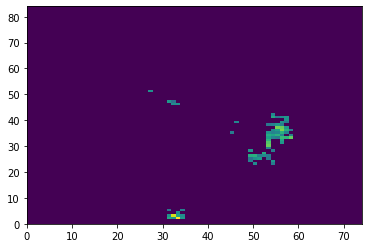

('C48H91NO11S', '-H') 0.2876089


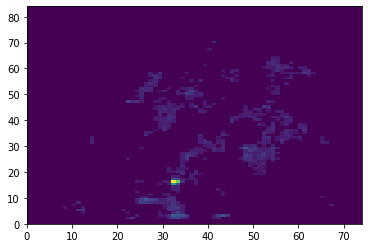

('C47H85O13P', '-H') 0.2773352


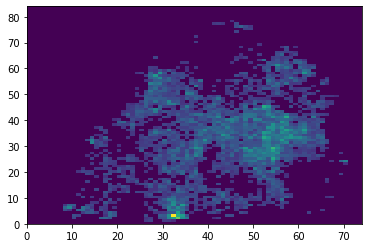

('C21H29N7O14P2', '-H') 0.19165842


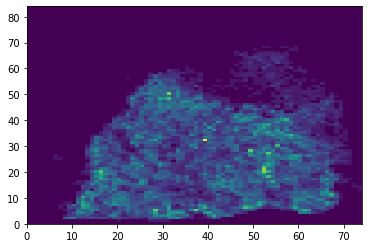

('C17H27N3O17P2', '-H') 0.16042115


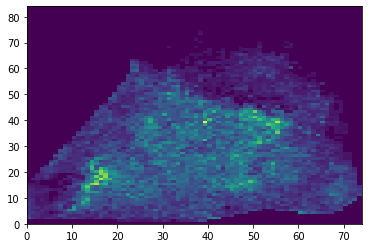

('C10H14N5O7P', '-H') 0.14541695


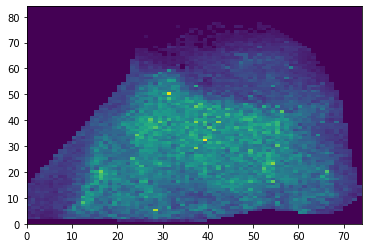

('C21H41O6P', '-H') 0.14256226


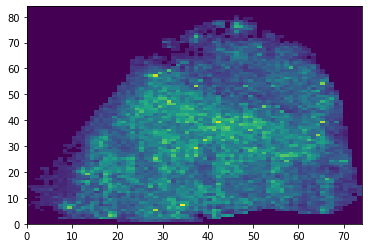

('C40H77NO11S', '-H') 0.12943415


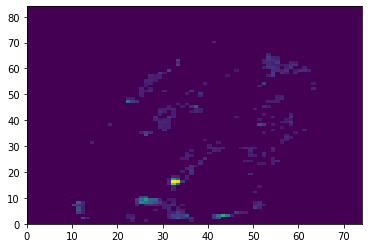

('C48H93NO11S', '-H') 0.07179103


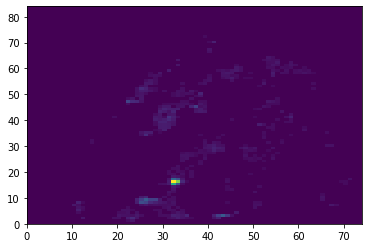

('C46H89NO11S', '-H') 0.047641918


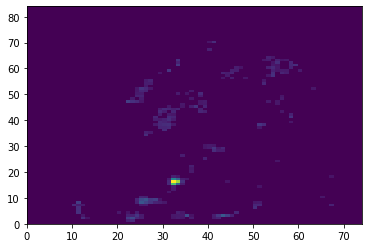

('C51H90O10P', '-H') 0.0


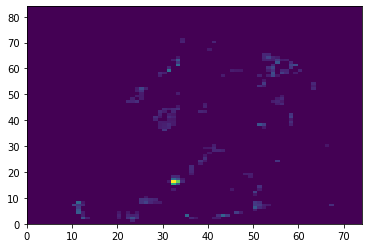

In [28]:
# choose random ion from the dataset and show n most similar ions according to measure of choice

%matplotlib inline
import matplotlib.pyplot as plt

n = 10
i = random.choice(range(len(ions)))
random_ion = ions[i]

def show_ion_img(ion):
    f_path = '%s/%s/%s_%s.npy' % (img_dir, random_ds_name, ion[0], ion[1])
    img = np.load(f_path)
    plt.pcolormesh(img,cmap='viridis')
    #plt.axes().set_aspect('equal', 'datalim')
    #plt.axes().axis('off')
    plt.show()
    
print('RANDOM ION:', random_ion)
show_ion_img(random_ion)
    
sims = cosine[i]
most_sim_inds = sims.argsort()[-(n+1):][::-1]
for j in most_sim_inds:
    if i == j: continue
    print(ions[j], sims[j])
    show_ion_img(ions[j])

In [ ]:
# compute similarities for gold standard

gs_file = '/data/katya/coloc/coloc_gs.csv'
coloc_gs_df = pd.read_csv(gs_file)
coloc_gs_df['rev_rank'] = 10-coloc_gs_df['rank']

for datasetId, dsrows in coloc_gs_df.groupby('datasetId'):  
    print(datasetId)
    ds_path = path.join(img_dir, datasetId)
    (ions, cosine, tfidf_cosine, pearson, spearman, ssims) = compute_similarities(ds_path)
    
    for i, row in dsrows.iterrows():
        base_i = ions.index((row.baseSf, row.baseAdduct))
        other_i = ions.index((row.otherSf, row.otherAdduct))
        coloc_gs_df.at[i, 'cosine'] = cosine[base_i][other_i]
        coloc_gs_df.at[i, 'tfidf_cosine'] = tfidf_cosine[base_i][other_i]
        coloc_gs_df.at[i, 'pearson'] = pearson[base_i][other_i]
        coloc_gs_df.at[i, 'spearman'] = spearman[base_i][other_i]
        coloc_gs_df.at[i, 'ssim'] = ssims[base_i][other_i]

2016-09-21_16h07m14s
2016-09-21_16h07m23s
2016-09-21_16h07m37s
2016-09-21_16h07m47s
2016-09-21_16h07m49s
2016-10-04_14h13m49s
2016-10-21_07h18m06s
2016-11-17_17h58m41s
2016-11-17_18h04m24s
2016-11-17_20h05m40s
2016-11-18_15h10m50s
2016-11-18_15h12m44s
2016-11-18_15h14m04s
2016-11-18_16h14m36s
2016-11-22_02h04m47s
2016-11-22_02h05m05s
2016-11-22_14h08m11s
2016-11-25_12h00m00s
2016-12-01_18h11m49s
2016-12-01_18h38m52s
2016-12-01_18h42m02s
2016-12-01_18h53m30s
2016-12-22_07h58m30s
2017-01-05_08h08m58s
2017-01-09_12h43m03s
2017-01-19_15h48m03s
2017-01-20_17h52m13s
2017-01-26_09h08m49s
2017-02-09_16h35m32s
2017-02-22_15h01m27s
2017-02-23_10h06m16s
2017-02-23_12h32m41s
2017-03-03_05h57m45s
2017-03-10_22h42m56s
2017-03-10_23h14m03s
2017-03-10_23h14m25s
2017-03-10_23h14m51s
2017-03-10_23h20m24s
2017-03-10_23h20m53s
2017-03-10_23h21m34s
2017-03-12_13h37m09s
2017-03-14_05h52m34s
2017-03-14_05h58m20s
2017-03-14_06h00m36s
2017-03-20_16h31m31s
2017-03-28_16h40m57s
2017-03-30_04h00m35s
2017-04-10_16

In [42]:
# evaluate gs measures
from scipy import stats
measures = ['cosine', 'tfidf_cosine', 'pearson', 'spearman', 'ssim']
set_results = pd.DataFrame(columns = ['measure', 'spearman', 'kendall'])

# calculate correlation coefficients for each set
counter = 0
for (d, s, a), rows in coloc_gs_df.groupby(['datasetId', 'baseSf', 'baseAdduct']):
    for m in measures:
        s = stats.spearmanr(rows.rev_rank.values, rows[m].values)
        k = stats.kendalltau(rows.rev_rank.values, rows[m].values)
        set_results.loc[counter] = [m, s[0], k[0]]
        counter += 1

# report average over sets
for m, rows in set_results.groupby('measure'):
    print('%s: spearman = %.3f, kendall = %.3f' % (m, rows['spearman'].mean(), rows['kendall'].mean()))

cosine: spearman = 0.794, kendall = 0.682
pearson: spearman = 0.775, kendall = 0.661
spearman: spearman = 0.729, kendall = 0.610
ssim: spearman = 0.614, kendall = 0.498
tfidf_cosine: spearman = 0.794, kendall = 0.682
